# Group 1 Workshop 1 - Stationary Points Analysis

This notebook analyzes the movement patterns of Group 1 from Workshop 1 to identify stationary points during the demonstration. We'll use clustering techniques to find locations where the group spent significant time with minimal movement.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load Group 1 Workshop 1 data
data_file = "../data/split/w1_g3.csv"

try:
    df = pd.read_csv(data_file)
    print(f"✅ Successfully loaded data from {data_file}")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst 5 rows:")
    display(df.head())
except FileNotFoundError:
    print(f"❌ File not found: {data_file}")
    print("Please check if the file path is correct.")
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")

✅ Successfully loaded data from ../data/split/w1_g3.csv
Dataset shape: (5358, 5)
Columns: ['name', 'x', 'y', 'z', 'time']

First 5 rows:


,name,x,y,z,time
0,Group 3,40.50,13.00,0.37,2025-07-11 12:50:27.61423
1,Group 3,40.41,12.96,-0.53,2025-07-11 12:50:27.749838
2,Group 3,40.59,12.95,-1.24,2025-07-11 12:50:28.753437
3,Group 3,40.53,12.99,-1.68,2025-07-11 12:50:29.749973
4,Group 3,40.48,13.00,-2.06,2025-07-11 12:50:30.750355


In [3]:
# Data preprocessing and exploration
# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Basic statistics
print("📊 Dataset Overview:")
print(f"   • Total data points: {len(df):,}")
print(f"   • Time period: {df['time'].min()} to {df['time'].max()}")
print(f"   • Duration: {(df['time'].max() - df['time'].min()).total_seconds() / 60:.1f} minutes")
print(f"   • Unique groups: {df['name'].unique()}")

print(f"\n📍 Coordinate Statistics:")
print(f"   • X range: {df['x'].min():.2f} to {df['x'].max():.2f} (range: {df['x'].max() - df['x'].min():.2f})")
print(f"   • Y range: {df['y'].min():.2f} to {df['y'].max():.2f} (range: {df['y'].max() - df['y'].min():.2f})")
if 'z' in df.columns:
    print(f"   • Z range: {df['z'].min():.2f} to {df['z'].max():.2f} (range: {df['z'].max() - df['z'].min():.2f})")

# Check data quality
print(f"\n🔍 Data Quality:")
print(f"   • Missing values: {df.isnull().sum().sum()}")
print(f"   • Sampling rate: ~{len(df) / ((df['time'].max() - df['time'].min()).total_seconds()):.1f} samples/second")

# Sort by time for temporal analysis
df = df.sort_values('time').reset_index(drop=True)

📊 Dataset Overview:
   • Total data points: 5,358
   • Time period: 2025-07-11 12:50:27.614230 to 2025-07-11 15:47:23.751670
   • Duration: 176.9 minutes
   • Unique groups: ['Group 3']

📍 Coordinate Statistics:
   • X range: 28.12 to 42.41 (range: 14.29)
   • Y range: 5.73 to 19.15 (range: 13.42)
   • Z range: -4.51 to 4.89 (range: 9.40)

🔍 Data Quality:
   • Missing values: 0
   • Sampling rate: ~0.5 samples/second


🚶 Movement Analysis:
   • Average speed: 0.091 units/second
   • Speed std dev: 0.111 units/second
   • Stationary threshold: 0.030 units/second
   • Stationary points: 1,340 (25.0%)


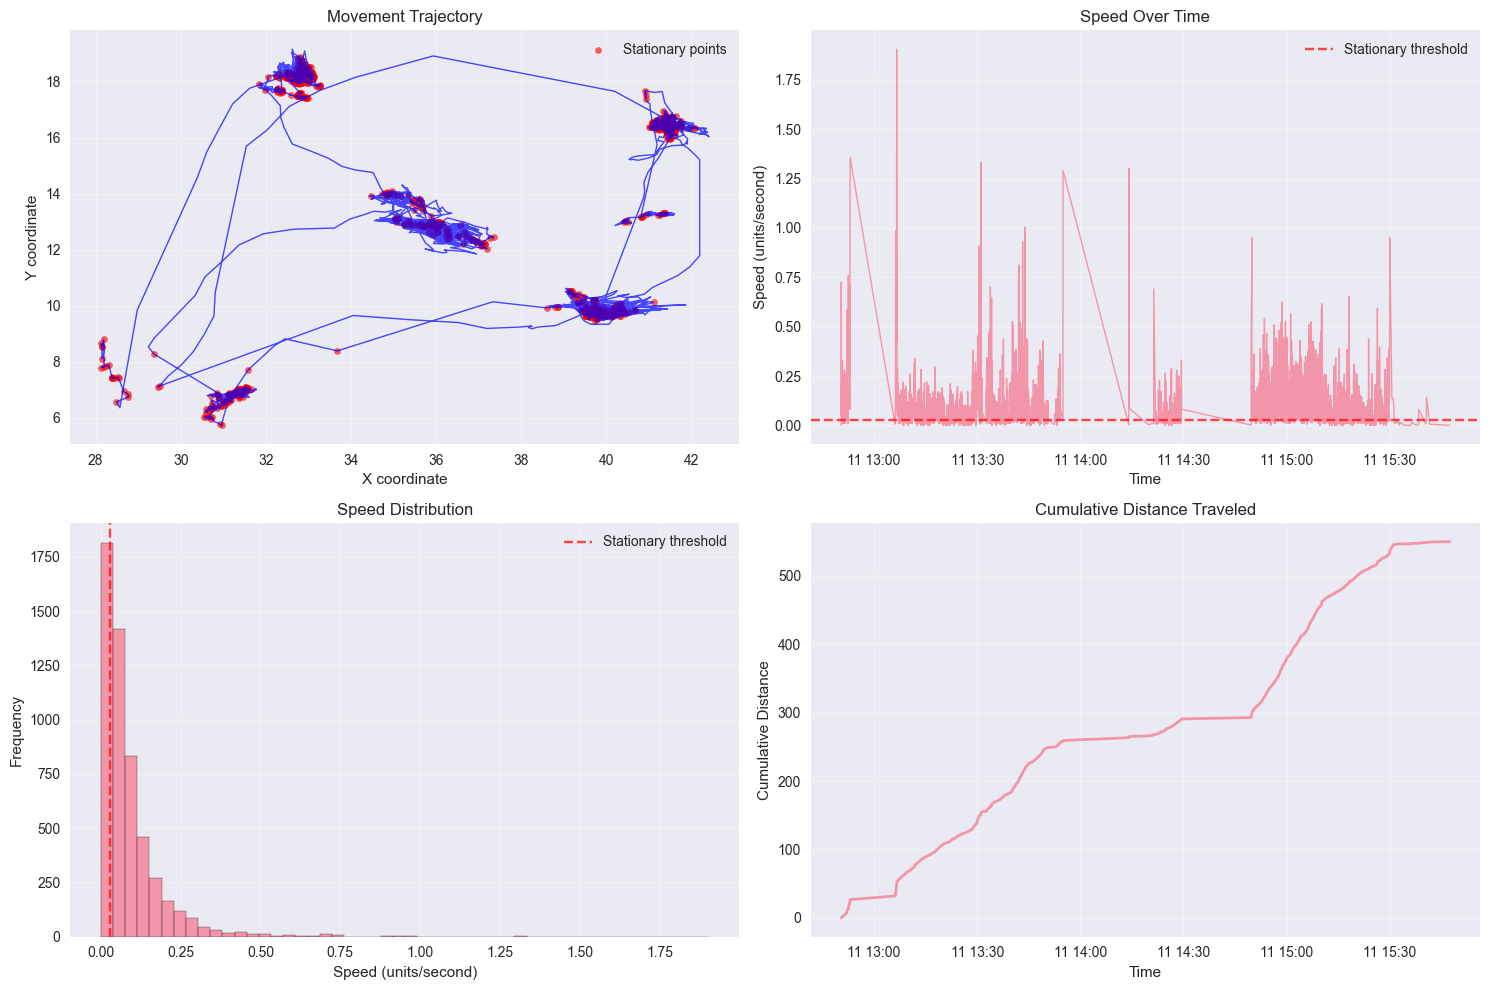

In [4]:
# Calculate movement metrics to identify stationary periods
def calculate_movement_metrics(df):
    """Calculate movement speed and identify stationary periods"""
    
    # Calculate time differences (in seconds)
    df['time_diff'] = df['time'].diff().dt.total_seconds()
    
    # Calculate distance moved between consecutive points
    df['x_diff'] = df['x'].diff()
    df['y_diff'] = df['y'].diff()
    df['distance'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2)
    
    # Calculate speed (distance/time)
    df['speed'] = df['distance'] / df['time_diff']
    df['speed'] = df['speed'].fillna(0)  # Fill NaN values with 0
    
    # Define stationary threshold (adjust based on your data characteristics)
    stationary_threshold = np.percentile(df['speed'], 25)  # Bottom 25% of speeds
    df['is_stationary'] = df['speed'] <= stationary_threshold
    
    return df, stationary_threshold

# Apply movement analysis
df, stationary_threshold = calculate_movement_metrics(df)

print(f"🚶 Movement Analysis:")
print(f"   • Average speed: {df['speed'].mean():.3f} units/second")
print(f"   • Speed std dev: {df['speed'].std():.3f} units/second")
print(f"   • Stationary threshold: {stationary_threshold:.3f} units/second")
print(f"   • Stationary points: {df['is_stationary'].sum():,} ({df['is_stationary'].mean()*100:.1f}%)")

# Visualize movement pattern over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Trajectory
axes[0, 0].plot(df['x'], df['y'], alpha=0.7, linewidth=1, color='blue')
axes[0, 0].scatter(df[df['is_stationary']]['x'], df[df['is_stationary']]['y'], 
                   c='red', s=20, alpha=0.6, label='Stationary points')
axes[0, 0].set_title('Movement Trajectory')
axes[0, 0].set_xlabel('X coordinate')
axes[0, 0].set_ylabel('Y coordinate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Speed over time
axes[0, 1].plot(df['time'], df['speed'], alpha=0.7, linewidth=1)
axes[0, 1].axhline(y=stationary_threshold, color='red', linestyle='--', alpha=0.7, label='Stationary threshold')
axes[0, 1].set_title('Speed Over Time')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Speed (units/second)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Speed histogram
axes[1, 0].hist(df['speed'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=stationary_threshold, color='red', linestyle='--', alpha=0.7, label='Stationary threshold')
axes[1, 0].set_title('Speed Distribution')
axes[1, 0].set_xlabel('Speed (units/second)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative distance
df['cumulative_distance'] = df['distance'].fillna(0).cumsum()
axes[1, 1].plot(df['time'], df['cumulative_distance'], alpha=0.7, linewidth=2)
axes[1, 1].set_title('Cumulative Distance Traveled')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Cumulative Distance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Clustering Analysis for Stationary Points

Now we'll apply clustering algorithms specifically to the stationary points to identify distinct locations where Group 1 spent significant time during the demonstration.

🎯 Stationary Points Analysis:
   • Total stationary points: 1,340
   • Percentage of total data: 25.0%
   • Coordinate range: X(28.12 to 42.07), Y(5.73 to 18.86)


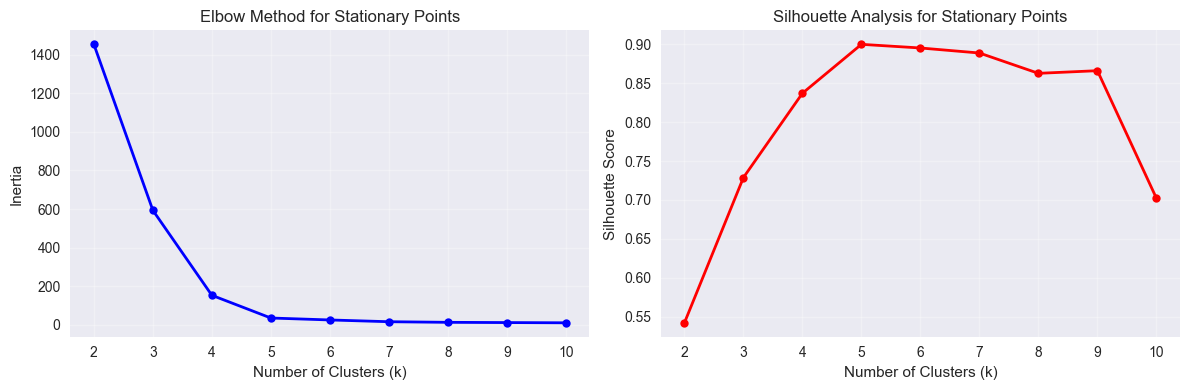

   • Optimal number of clusters: 5
   • Best silhouette score: 0.900


In [5]:
# Extract stationary points for clustering
stationary_points = df[df['is_stationary']].copy()

print(f"🎯 Stationary Points Analysis:")
print(f"   • Total stationary points: {len(stationary_points):,}")
print(f"   • Percentage of total data: {len(stationary_points)/len(df)*100:.1f}%")

if len(stationary_points) < 10:
    print("⚠️  Too few stationary points for meaningful clustering analysis")
else:
    # Prepare coordinates for clustering
    stationary_coords = stationary_points[['x', 'y']].values
    
    # Standardize coordinates
    scaler = StandardScaler()
    stationary_coords_scaled = scaler.fit_transform(stationary_coords)
    
    print(f"   • Coordinate range: X({stationary_points['x'].min():.2f} to {stationary_points['x'].max():.2f}), Y({stationary_points['y'].min():.2f} to {stationary_points['y'].max():.2f})")
    
    # Find optimal number of clusters using multiple methods
    def find_optimal_clusters_stationary(data, max_k=10):
        """Find optimal number of clusters for stationary points"""
        max_k = min(max_k, len(data) // 5)  # Ensure reasonable cluster sizes
        
        if max_k < 2:
            return None, None, None
            
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_k + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(data)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(data, labels))
        
        return k_range, inertias, silhouette_scores
    
    # Find optimal clusters
    k_range, inertias, silhouette_scores = find_optimal_clusters_stationary(stationary_coords_scaled)
    
    if k_range is not None:
        # Plot clustering metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Elbow method
        ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Stationary Points')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette scores
        ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=6)
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Analysis for Stationary Points')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Find best k
        best_k = k_range[np.argmax(silhouette_scores)]
        best_silhouette = max(silhouette_scores)
        
        print(f"   • Optimal number of clusters: {best_k}")
        print(f"   • Best silhouette score: {best_silhouette:.3f}")
    else:
        print("⚠️  Not enough variation in stationary points for clustering")

🔍 Clustering Results:
   • K-Means clusters: 5
   • K-Means silhouette score: 0.900
   • DBSCAN clusters: 0
   • DBSCAN noise points: 1340

📍 Stationary Locations (K-Means Centers):
   • Location 1: (39.74, 9.84) - 245 data points
   • Location 2: (32.81, 18.10) - 396 data points
   • Location 3: (41.39, 16.38) - 446 data points
   • Location 4: (30.77, 6.93) - 136 data points
   • Location 5: (35.89, 13.00) - 117 data points


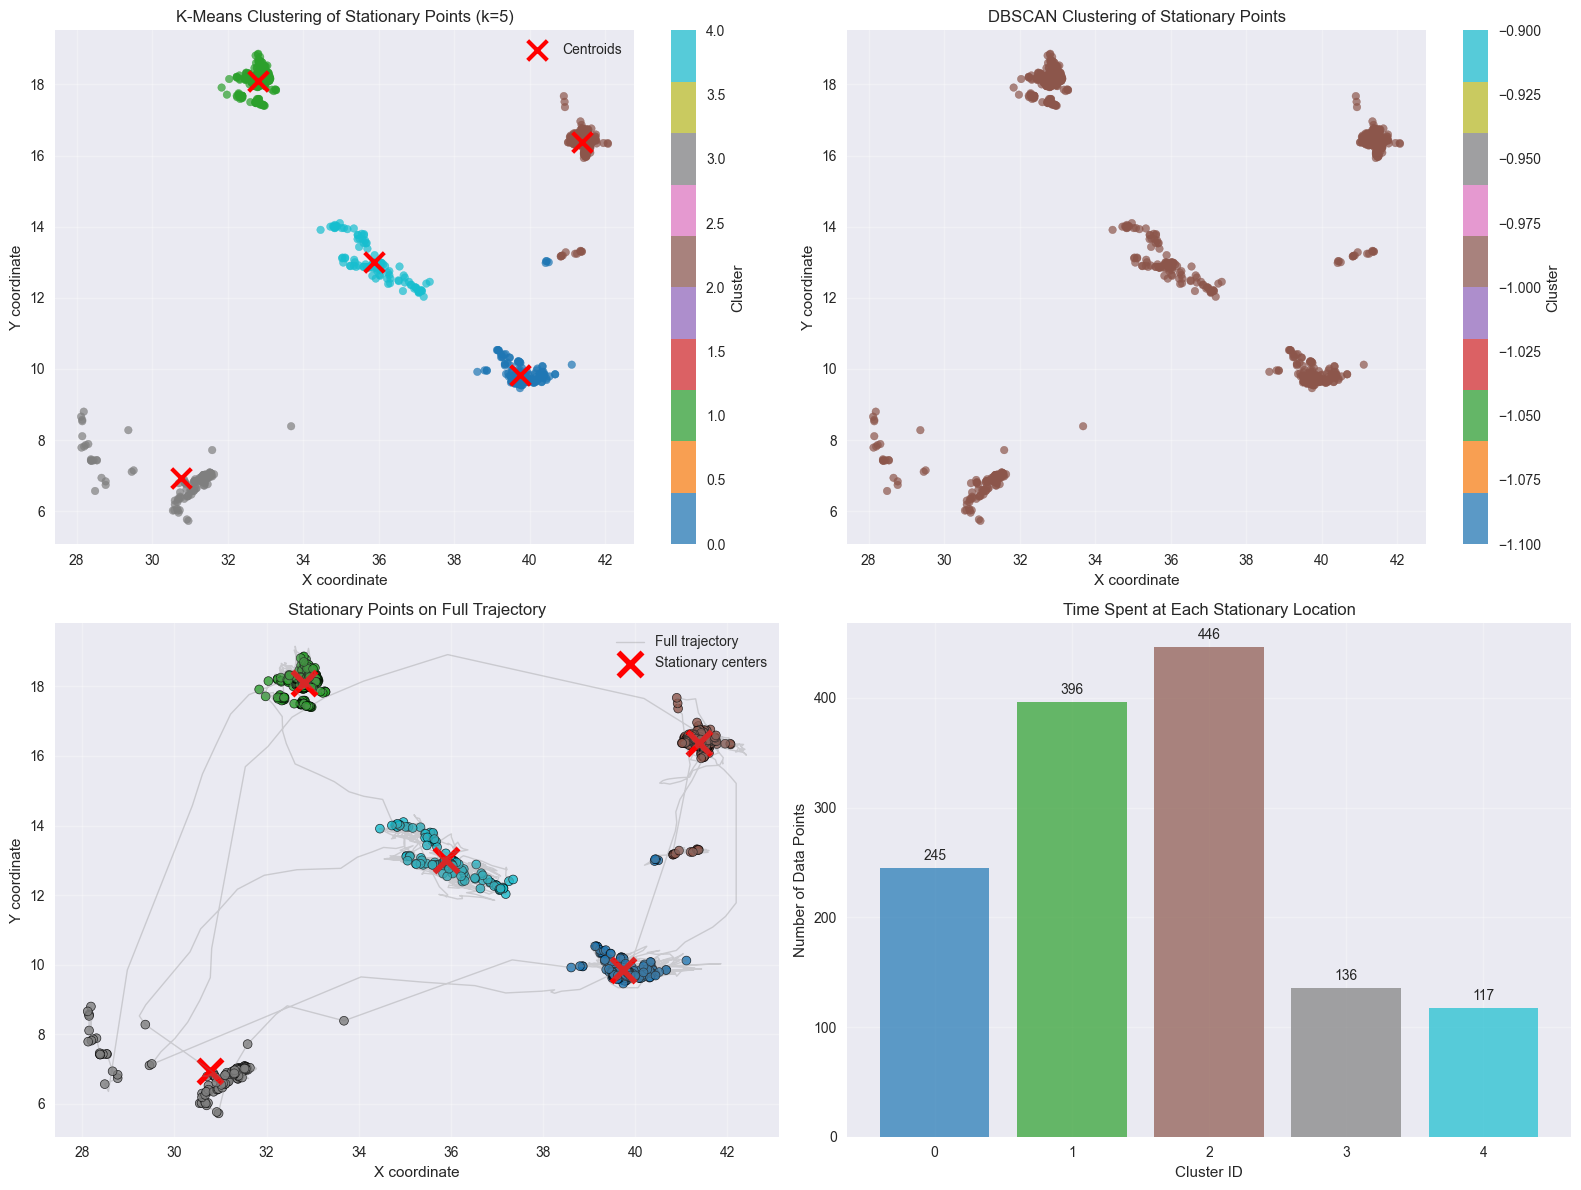

In [6]:
# Apply clustering algorithms to stationary points
if len(stationary_points) >= 10 and k_range is not None:
    
    # 1. K-Means clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    stationary_kmeans_labels = kmeans.fit_predict(stationary_coords_scaled)
    
    # 2. DBSCAN clustering (density-based)
    # Estimate eps parameter based on k-distance
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(stationary_coords_scaled)
    distances, indices = neighbors_fit.kneighbors(stationary_coords_scaled)
    distances = np.sort(distances[:, 3], axis=0)
    
    # Use knee point estimation for eps
    eps = np.percentile(distances, 75)  # Use 75th percentile as eps
    dbscan = DBSCAN(eps=eps, min_samples=max(3, len(stationary_points)//20))
    stationary_dbscan_labels = dbscan.fit_predict(stationary_coords_scaled)
    
    # Add cluster labels to stationary points
    stationary_points = stationary_points.copy()
    stationary_points['kmeans_cluster'] = stationary_kmeans_labels
    stationary_points['dbscan_cluster'] = stationary_dbscan_labels
    
    # Get cluster centers (in original coordinates)
    kmeans_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    
    print(f"🔍 Clustering Results:")
    print(f"   • K-Means clusters: {len(np.unique(stationary_kmeans_labels))}")
    print(f"   • K-Means silhouette score: {silhouette_score(stationary_coords_scaled, stationary_kmeans_labels):.3f}")
    print(f"   • DBSCAN clusters: {len(np.unique(stationary_dbscan_labels[stationary_dbscan_labels != -1]))}")
    print(f"   • DBSCAN noise points: {np.sum(stationary_dbscan_labels == -1)}")
    
    # Print cluster centers and statistics
    print(f"\n📍 Stationary Locations (K-Means Centers):")
    for i, center in enumerate(kmeans_centers):
        cluster_points = stationary_points[stationary_points['kmeans_cluster'] == i]
        duration = len(cluster_points)  # Number of data points (proxy for time spent)
        print(f"   • Location {i+1}: ({center[0]:.2f}, {center[1]:.2f}) - {duration} data points")
    
    # Visualize clustering results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: K-Means results
    scatter1 = axes[0, 0].scatter(stationary_points['x'], stationary_points['y'], 
                                  c=stationary_points['kmeans_cluster'], cmap='tab10', 
                                  alpha=0.7, s=30)
    axes[0, 0].scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], 
                      c='red', marker='x', s=200, linewidths=3, label='Centroids')
    axes[0, 0].set_title(f'K-Means Clustering of Stationary Points (k={best_k})')
    axes[0, 0].set_xlabel('X coordinate')
    axes[0, 0].set_ylabel('Y coordinate')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')
    
    # Plot 2: DBSCAN results
    scatter2 = axes[0, 1].scatter(stationary_points['x'], stationary_points['y'], 
                                  c=stationary_points['dbscan_cluster'], cmap='tab10', 
                                  alpha=0.7, s=30)
    axes[0, 1].set_title(f'DBSCAN Clustering of Stationary Points')
    axes[0, 1].set_xlabel('X coordinate')
    axes[0, 1].set_ylabel('Y coordinate')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')
    
    # Plot 3: Full trajectory with stationary clusters highlighted
    axes[1, 0].plot(df['x'], df['y'], alpha=0.3, linewidth=1, color='gray', label='Full trajectory')
    axes[1, 0].scatter(stationary_points['x'], stationary_points['y'], 
                      c=stationary_points['kmeans_cluster'], cmap='tab10', 
                      alpha=0.8, s=40, edgecolors='black', linewidth=0.5)
    axes[1, 0].scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], 
                      c='red', marker='x', s=300, linewidths=4, label='Stationary centers')
    axes[1, 0].set_title('Stationary Points on Full Trajectory')
    axes[1, 0].set_xlabel('X coordinate')
    axes[1, 0].set_ylabel('Y coordinate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Time spent in each cluster
    cluster_durations = stationary_points['kmeans_cluster'].value_counts().sort_index()
    bars = axes[1, 1].bar(cluster_durations.index, cluster_durations.values, 
                         color=plt.cm.tab10(np.linspace(0, 1, len(cluster_durations))), alpha=0.7)
    axes[1, 1].set_title('Time Spent at Each Stationary Location')
    axes[1, 1].set_xlabel('Cluster ID')
    axes[1, 1].set_ylabel('Number of Data Points')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, duration in zip(bars, cluster_durations.values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_durations.values)*0.01,
                        f'{duration}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  Insufficient data for clustering analysis")


⏱️  Temporal Analysis:
   • Number of stationary episodes: 81
   • Average episode duration: 33.0 seconds
   • Longest episode: 249.0 seconds
   • Shortest episode: 2.0 seconds


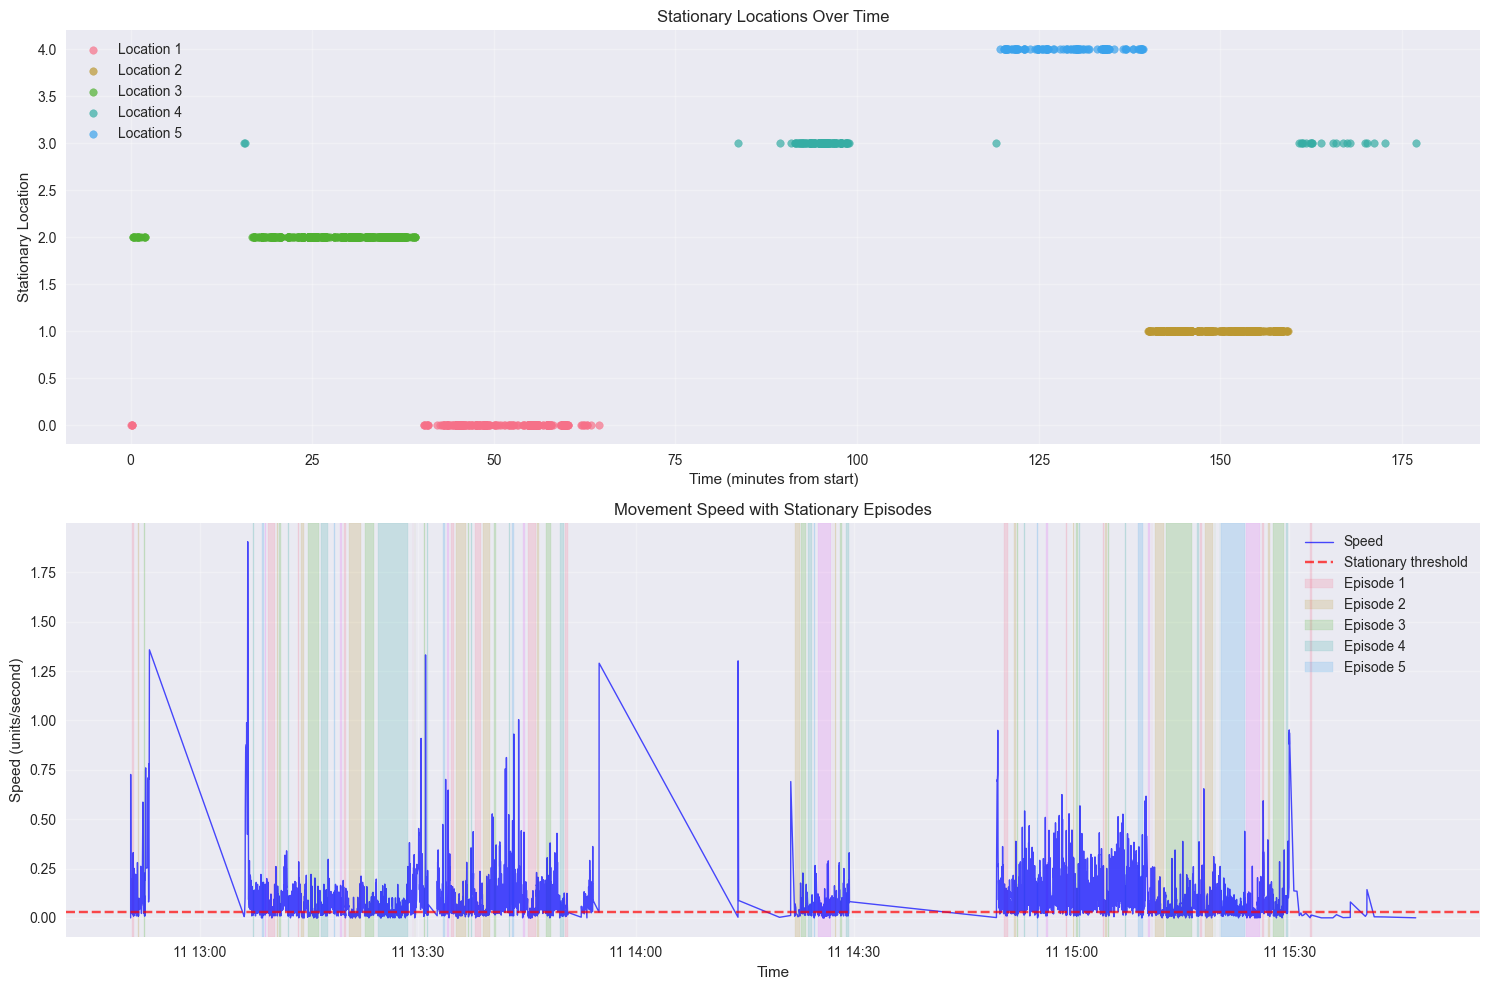


📋 Stationary Points Summary Report:
   • Total demonstration time: 176.9 minutes
   • Time spent stationary: 25.0% of total time
   • Number of distinct stationary locations: 5
   • Average time per location: 268 data points
   • Number of stationary episodes: 81
   • Average episode duration: 33.0 seconds

📍 Key Stationary Locations:
   • Location 1: (39.74, 9.84) - 18.3% of stationary time
   • Location 2: (32.81, 18.10) - 29.6% of stationary time
   • Location 3: (41.39, 16.38) - 33.3% of stationary time
   • Location 4: (30.77, 6.93) - 10.1% of stationary time
   • Location 5: (35.89, 13.00) - 8.7% of stationary time


In [7]:
# Temporal analysis of stationary periods
if len(stationary_points) >= 10 and k_range is not None:
    
    # Analyze when stationary periods occurred
    stationary_points['time_minutes'] = (stationary_points['time'] - stationary_points['time'].min()).dt.total_seconds() / 60
    
    # Group consecutive stationary points into episodes
    def identify_stationary_episodes(df, max_gap_seconds=10):
        """Identify continuous episodes of stationary behavior"""
        episodes = []
        current_episode = []
        
        for i, row in df.iterrows():
            if len(current_episode) == 0:
                current_episode = [row]
            else:
                time_gap = (row['time'] - current_episode[-1]['time']).total_seconds()
                if time_gap <= max_gap_seconds:
                    current_episode.append(row)
                else:
                    if len(current_episode) >= 3:  # Minimum episode length
                        episodes.append(current_episode)
                    current_episode = [row]
        
        # Add the last episode if it's long enough
        if len(current_episode) >= 3:
            episodes.append(current_episode)
        
        return episodes
    
    episodes = identify_stationary_episodes(stationary_points.reset_index())
    
    print(f"\n⏱️  Temporal Analysis:")
    print(f"   • Number of stationary episodes: {len(episodes)}")
    if len(episodes) > 0:
        episode_durations = [(episode[-1]['time'] - episode[0]['time']).total_seconds() for episode in episodes]
        print(f"   • Average episode duration: {np.mean(episode_durations):.1f} seconds")
        print(f"   • Longest episode: {max(episode_durations):.1f} seconds")
        print(f"   • Shortest episode: {min(episode_durations):.1f} seconds")
    
    # Create temporal visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Stationary points over time with clusters
    for cluster_id in sorted(stationary_points['kmeans_cluster'].unique()):
        cluster_data = stationary_points[stationary_points['kmeans_cluster'] == cluster_id]
        axes[0].scatter(cluster_data['time_minutes'], cluster_data['kmeans_cluster'], 
                       label=f'Location {cluster_id+1}', alpha=0.7, s=30)
    
    axes[0].set_title('Stationary Locations Over Time')
    axes[0].set_xlabel('Time (minutes from start)')
    axes[0].set_ylabel('Stationary Location')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Speed over time with stationary periods highlighted
    axes[1].plot(df['time'], df['speed'], alpha=0.7, linewidth=1, color='blue', label='Speed')
    axes[1].axhline(y=stationary_threshold, color='red', linestyle='--', alpha=0.7, label='Stationary threshold')
    
    # Highlight stationary episodes
    for i, episode in enumerate(episodes):
        start_time = episode[0]['time']
        end_time = episode[-1]['time']
        axes[1].axvspan(start_time, end_time, alpha=0.2, color=f'C{i%10}', 
                       label=f'Episode {i+1}' if i < 5 else '')
    
    axes[1].set_title('Movement Speed with Stationary Episodes')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Speed (units/second)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary report
    print(f"\n📋 Stationary Points Summary Report:")
    print(f"   • Total demonstration time: {(df['time'].max() - df['time'].min()).total_seconds() / 60:.1f} minutes")
    print(f"   • Time spent stationary: {len(stationary_points) / len(df) * 100:.1f}% of total time")
    print(f"   • Number of distinct stationary locations: {best_k}")
    print(f"   • Average time per location: {len(stationary_points) / best_k:.0f} data points")
    
    if len(episodes) > 0:
        print(f"   • Number of stationary episodes: {len(episodes)}")
        print(f"   • Average episode duration: {np.mean(episode_durations):.1f} seconds")
    
    print(f"\n📍 Key Stationary Locations:")
    for i, center in enumerate(kmeans_centers):
        cluster_points = stationary_points[stationary_points['kmeans_cluster'] == i]
        duration_pct = len(cluster_points) / len(stationary_points) * 100
        print(f"   • Location {i+1}: ({center[0]:.2f}, {center[1]:.2f}) - {duration_pct:.1f}% of stationary time")

else:
    print("⚠️  Insufficient stationary data for temporal analysis")